Import pakages
======

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import numpy as np
import matplotlib.pyplot as plt

c:\ProgramData\Anaconda3\envs\test1\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


Setting cpu/gpu use and hyperparameters
======


Setting cpu or gpu
-----

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Setting hyperparameters
----

In [3]:
hidden_dim1 = 300
hidden_dim2 = 100
latent_dim = 16
BETA = 1.0
BATCH_SIZE = 50
NUM_WORKERS = 2
LR = 0.001
MAX_EPOCHS = 100

Download datas
======

In [4]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.MNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

Define models
====

Encoder
------
Let $\mu$ and $\Sigma$ be the learned parameters for latent space, which follows Multi-Variate Normal distribution.
Since we assume that each dimension is independent to another, the covariance matrix is 
$$ \Sigma = 
\begin{bmatrix}
\sigma_1^2 & 0 & \cdots & 0\\
0 & \sigma_2^2 & \cdots & 0\\
0 & 0 & \ddots & 0 \\
0 & 0 & \cdots & \sigma_n^2
\end{bmatrix}
$$

Then, the p.d.f. of MVN is as follows:
$$ N(\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^n|\det{\Sigma}|}} \exp\left({-\frac{1}{2}(\mathbb{x}-\mu)^T \Sigma^{-1} (\mathbb{x}-\mu)}\right)$$ 

The prior distribution is $N(0,I)$, whose p.d.f. is as follows:
$$ N(0,I) = \frac{1}{\sqrt{(2\pi)^n|\det{I}|}} \exp\left(-\frac{1}{2}\mathbb{x}^T\mathbb{x}\right) $$

Then, the KL divergence loss is computed as below.

\begin{align*}
D_{KL}(N(\mu, \Sigma) || N(0,I)) &= \mathbb{E}_{\mathbb{x} \sim N(\mu, \Sigma)} \left( \log\frac{N(\mu, \Sigma)}{N(0, I)}\right) \\
&= \mathbb{E}_{\mathbb{x} \sim N(\mu, \Sigma)} \left( -\frac{1}{2}\log\prod_{i=1}^n \sigma_i^2 -\frac{1}{2}(\mathbb{x}-\mu)^T \Sigma^{-1} (\mathbb{x}-\mu) +\frac{1}{2}\mathbb{x}^T\mathbb{x}\right) \\
&= \int_{\mathbb{R}^n} \left( -\frac{1}{2}\sum_{i=1}^n\log\sigma_i^2 -\frac{1}{2}\sum_{i=1}^n \frac{(x_i-\mu_i)^2}{\sigma_i^2} +\frac{1}{2} \sum_{i=1}^n x_i^2\right) N(\mu, \Sigma) d\mathbb{x} \\
&=  -\frac{1}{2}\sum_{i=1}^n\log\sigma_i^2 -\frac{1}{2}\sum_{i=1}^n \frac{\sigma_i^2}{\sigma_i^2} + \frac{1}{2} \sum_{i=1}^n (\mu_i^2 + \sigma_i^2) \\
&= -\frac{1}{2}\sum_{i=1}^n \left( 1 + \log \sigma_i^2 -\mu_i^2 - \sigma_i^2 \right)
\end{align*}

Note that since each dimension of $\mathbb{x}$ is independent to another, we have
$$ N(\mu, \Sigma) = \prod_{i=1}^n N(\mu_i, \sigma_i^2) $$

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims1, hidden_dims2):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, hidden_dims1).to(device)
        self.relu1 = nn.ReLU().to(device)
        self.linear2 = nn.Linear(hidden_dims1, hidden_dims2).to(device)
        self.relu2 = nn.ReLU().to(device)
        self.linear_m = nn.Linear(hidden_dims2, latent_dims).to(device)
        self.linear_s = nn.Linear(hidden_dims2, latent_dims).to(device)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x.to(device)
        x = torch.flatten(x, start_dim=1).to(device)
        x = self.linear1(x).to(device)
        x = self.relu1(x).to(device)
        x = self.linear2(x).to(device)
        x = self.relu2(x).to(device)
        mu =  self.linear_m(x).to(device)
        sigma = torch.exp(self.linear_s(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5 * (sigma**2) + 0.5 * (mu**2) - torch.log(sigma) - 0.5).sum()
        return z, mu, sigma

Decoder
-------

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims2, hidden_dims1):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden_dims2).to(device)
        self.relu1 = nn.ReLU().to(device)
        self.linear2 = nn.Linear(hidden_dims2, hidden_dims1).to(device)
        self.relu2 = nn.ReLU().to(device)
        self.linear3 = nn.Linear(hidden_dims1, 784).to(device)
        self.sigmoid = nn.Sigmoid().to(device)

    def forward(self, z):
        z = z.to(device)
        z = self.linear1(z)
        z = self.relu1(z)
        z = self.linear2(z)
        z = self.relu2(z)
        z = self.linear3(z)
        z = self.sigmoid(z)
        return z.reshape((-1, 1, 28, 28))

Autoencoder
--------
Combine encoder and decoder to make autoencoder

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims1, hidden_dims2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, hidden_dims1, hidden_dims2).to(device)
        self.decoder = Decoder(latent_dims, hidden_dims2, hidden_dims1).to(device)

    def forward(self, x):
        z, dummy1, dummy2 = self.encoder(x)
        return self.decoder(z)

Choose sample from testset
=======
Choose sample from testset. We will compare between original image and decoded image during training.

In [8]:
idx = 421
sample = testset.data[idx] / 255.0
sample = sample.view(-1,28,28)
sample = sample.to(device)

Training
=====

In [9]:
def train(autoencoder, data1, data2, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=LR)
    res = []
    kls = []
    tots = []
    res2 = []
    kls2 = []
    tots2 = []
    for epoch in range(epochs):
        autoencoder.train()
        print("[Epoch " + str(epoch + 1) + "]")
        total_reconstruction_loss = 0
        total_kl_div = 0
        for x, y in data1:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            total_reconstruction_loss = total_reconstruction_loss + ((x - x_hat)**2).sum()
            total_kl_div = total_kl_div + autoencoder.encoder.kl
            loss = ((x - x_hat)**2).sum() + BETA * autoencoder.encoder.kl
            loss.backward()
            opt.step()
        re = total_reconstruction_loss.item()/60000.0
        kl = total_kl_div.item()/60000.0
        tot = re + BETA * kl
        res.append(re)
        kls.append(kl)
        tots.append(tot)
        print("For train data\n")
        print("Reconstruction : " + str(re) + "\n" + "KL Divergence : " + str(kl) + "\n" + "Total loss : " + str(tot))
        autoencoder.eval()
        total_reconstruction_loss = 0
        total_kl_div = 0
        for x, y in data2:
            x = x.to(device)
            x_hat = autoencoder(x)
            total_reconstruction_loss = total_reconstruction_loss + ((x - x_hat)**2).sum()
            total_kl_div = total_kl_div + autoencoder.encoder.kl
            loss = ((x - x_hat)**2).sum() + BETA * autoencoder.encoder.kl

        re = total_reconstruction_loss.item()/10000.0
        kl = total_kl_div.item()/10000.0
        tot = re + BETA * kl
        print("\n"+"For test data\n")
        print("Reconstruction : " + str(re) + "\n" + "KL Divergence : " + str(kl) + "\n" + "Total loss : " + str(tot))
        res2.append(re)
        kls2.append(kl)
        tots2.append(tot)

        z, mu, sigma = autoencoder.encoder(sample)
        z.to(device)
        mu.to(device)
        sigma.to(device)
        epsilon = torch.rand_like(mu).to(device)
        latent = mu + sigma * epsilon * 1.0
        decoded_sample = autoencoder.decoder(latent)
        sample_np = sample.cpu().detach().numpy()
        decoded_np = decoded_sample.cpu().detach().numpy()
        original = np.reshape(sample_np, (28,28))
        make = np.reshape(decoded_np, (28,28))
        plt.subplot(1, 2, 1) 
        plt.imshow(original, cmap='gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(make, cmap='gray')
        plt.show()
      
                  
    return autoencoder, res, kls, tots, res2, kls2, tots2

In [10]:
vae = VariationalAutoencoder(latent_dims= latent_dim, hidden_dims1 = hidden_dim1, hidden_dims2 = hidden_dim2).to(device)

In [11]:
summary_(vae.encoder, input_size=(28,28,), batch_size = BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [50, 300]         235,500
              ReLU-2                  [50, 300]               0
            Linear-3                  [50, 100]          30,100
              ReLU-4                  [50, 100]               0
            Linear-5                   [50, 16]           1,616
            Linear-6                   [50, 16]           1,616
Total params: 268,832
Trainable params: 268,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 0.32
Params size (MB): 1.03
Estimated Total Size (MB): 1.49
----------------------------------------------------------------


In [12]:
summary_(vae.decoder, input_size=(latent_dim,), batch_size = BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [50, 100]           1,700
              ReLU-2                  [50, 100]               0
            Linear-3                  [50, 300]          30,300
              ReLU-4                  [50, 300]               0
            Linear-5                  [50, 784]         235,984
           Sigmoid-6                  [50, 784]               0
Total params: 267,984
Trainable params: 267,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.90
Params size (MB): 1.02
Estimated Total Size (MB): 1.93
----------------------------------------------------------------


In [13]:
summary_(vae, input_size=(28,28,), batch_size = BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [50, 300]         235,500
              ReLU-2                  [50, 300]               0
            Linear-3                  [50, 100]          30,100
              ReLU-4                  [50, 100]               0
            Linear-5                   [50, 16]           1,616
            Linear-6                   [50, 16]           1,616
           Encoder-7  [[-1, 16], [-1, 16], [-1, 16]]               0
            Linear-8                  [50, 100]           1,700
              ReLU-9                  [50, 100]               0
           Linear-10                  [50, 300]          30,300
             ReLU-11                  [50, 300]               0
           Linear-12                  [50, 784]         235,984
          Sigmoid-13                  [50, 784]               0
          Decoder-14            [5

[Epoch 1]
For train data

Reconstruction : 39.50064583333333
KL Divergence : 4.5748927083333335
Total loss : 44.07553854166666

For test data

Reconstruction : 27.9569125
KL Divergence : 7.34828046875
Total loss : 35.30519296875


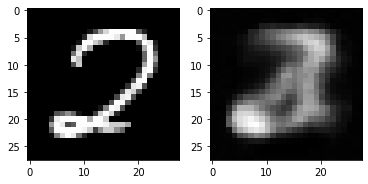

[Epoch 2]
For train data

Reconstruction : 26.21335
KL Divergence : 7.8662140625
Total loss : 34.0795640625

For test data

Reconstruction : 24.16711875
KL Divergence : 8.55076640625
Total loss : 32.71788515625


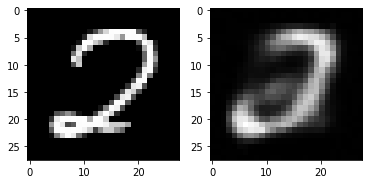

[Epoch 3]
For train data

Reconstruction : 23.7549625
KL Divergence : 8.581006770833334
Total loss : 32.33596927083333

For test data

Reconstruction : 22.9380578125
KL Divergence : 8.6825265625
Total loss : 31.620584375


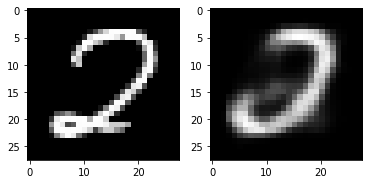

[Epoch 4]
For train data

Reconstruction : 22.37243125
KL Divergence : 8.948005208333333
Total loss : 31.320436458333333

For test data

Reconstruction : 21.7182125
KL Divergence : 9.18866328125
Total loss : 30.90687578125


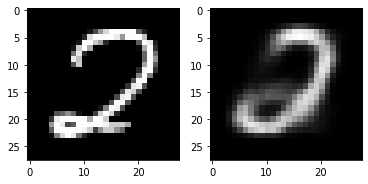

[Epoch 5]
For train data

Reconstruction : 21.5410125
KL Divergence : 9.206121875
Total loss : 30.747134375

For test data

Reconstruction : 21.1682140625
KL Divergence : 9.2017734375
Total loss : 30.3699875


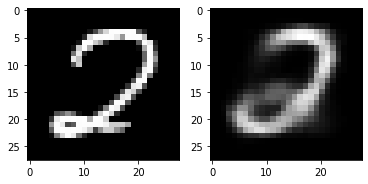

[Epoch 6]
For train data

Reconstruction : 20.952172916666665
KL Divergence : 9.370111458333334
Total loss : 30.322284375

For test data

Reconstruction : 20.4717421875
KL Divergence : 9.541159375
Total loss : 30.012901562499998


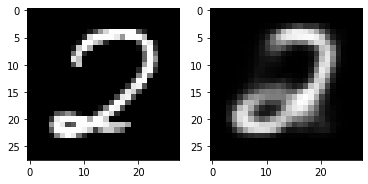

[Epoch 7]
For train data

Reconstruction : 20.467585416666665
KL Divergence : 9.516520833333333
Total loss : 29.984106249999996

For test data

Reconstruction : 20.281409375
KL Divergence : 9.388334375
Total loss : 29.66974375


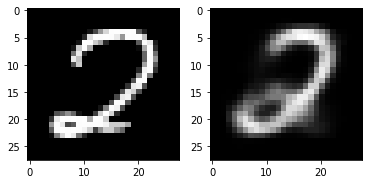

[Epoch 8]
For train data

Reconstruction : 20.068527083333333
KL Divergence : 9.628314583333333
Total loss : 29.696841666666664

For test data

Reconstruction : 20.1654171875
KL Divergence : 9.47422734375
Total loss : 29.63964453125


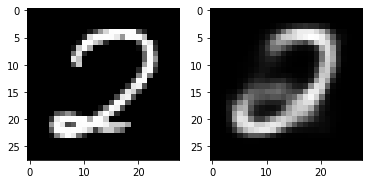

[Epoch 9]
For train data

Reconstruction : 19.7837125
KL Divergence : 9.714069791666667
Total loss : 29.497782291666667

For test data

Reconstruction : 19.6075359375
KL Divergence : 9.62780703125
Total loss : 29.23534296875


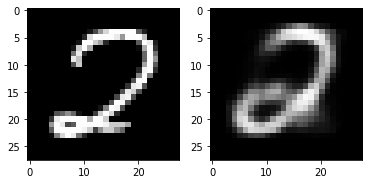

[Epoch 10]
For train data

Reconstruction : 19.518827083333335
KL Divergence : 9.795191666666666
Total loss : 29.314018750000002

For test data

Reconstruction : 19.274715625
KL Divergence : 9.871496875
Total loss : 29.146212499999997


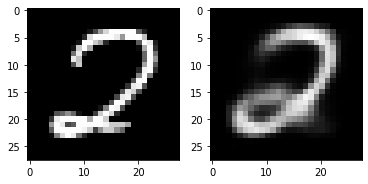

[Epoch 11]
For train data

Reconstruction : 19.3047125
KL Divergence : 9.843895833333333
Total loss : 29.148608333333335

For test data

Reconstruction : 19.1119296875
KL Divergence : 9.98490390625
Total loss : 29.096833593750002


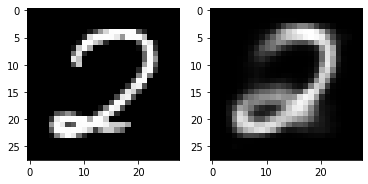

[Epoch 12]
For train data

Reconstruction : 19.129783333333332
KL Divergence : 9.896873958333334
Total loss : 29.026657291666666

For test data

Reconstruction : 18.8750953125
KL Divergence : 10.1714421875
Total loss : 29.0465375


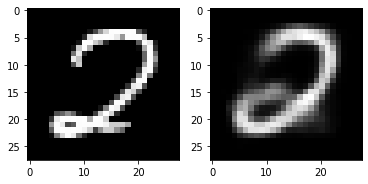

[Epoch 13]
For train data

Reconstruction : 18.968022916666666
KL Divergence : 9.951538541666666
Total loss : 28.919561458333334

For test data

Reconstruction : 18.499071875
KL Divergence : 10.28710703125
Total loss : 28.78617890625


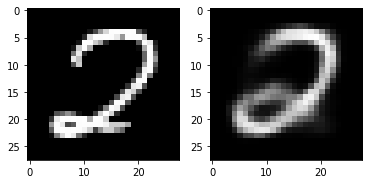

[Epoch 14]
For train data

Reconstruction : 18.83873125
KL Divergence : 9.990633333333333
Total loss : 28.82936458333333

For test data

Reconstruction : 18.6024109375
KL Divergence : 10.18606171875
Total loss : 28.78847265625


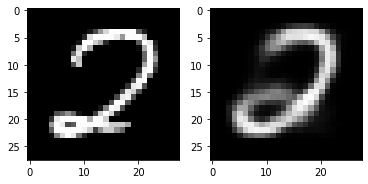

[Epoch 15]
For train data

Reconstruction : 18.712329166666667
KL Divergence : 10.045205208333334
Total loss : 28.757534375

For test data

Reconstruction : 18.5051609375
KL Divergence : 10.14489453125
Total loss : 28.65005546875


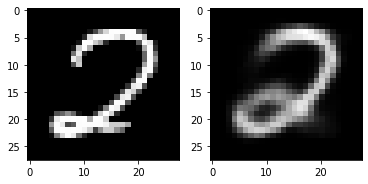

[Epoch 16]
For train data

Reconstruction : 18.6122875
KL Divergence : 10.073438541666667
Total loss : 28.68572604166667

For test data

Reconstruction : 18.73525625
KL Divergence : 9.87408984375
Total loss : 28.60934609375


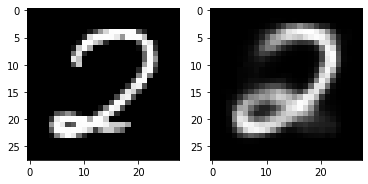

[Epoch 17]
For train data

Reconstruction : 18.514785416666665
KL Divergence : 10.101903125
Total loss : 28.616688541666665

For test data

Reconstruction : 18.2092875
KL Divergence : 10.510475
Total loss : 28.719762499999998


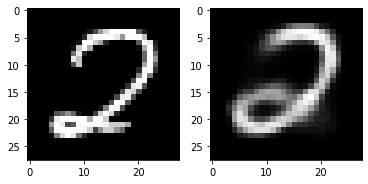

[Epoch 18]
For train data

Reconstruction : 18.398829166666665
KL Divergence : 10.125998958333334
Total loss : 28.524828125

For test data

Reconstruction : 18.4692203125
KL Divergence : 10.002165625
Total loss : 28.4713859375


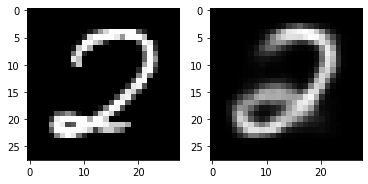

[Epoch 19]
For train data

Reconstruction : 18.326725
KL Divergence : 10.13029375
Total loss : 28.45701875

For test data

Reconstruction : 18.4748984375
KL Divergence : 10.02842109375
Total loss : 28.50331953125


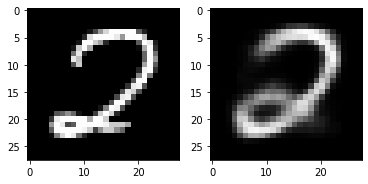

[Epoch 20]
For train data

Reconstruction : 18.262966666666667
KL Divergence : 10.167248958333333
Total loss : 28.430215625000002

For test data

Reconstruction : 18.3882953125
KL Divergence : 10.0148796875
Total loss : 28.403174999999997


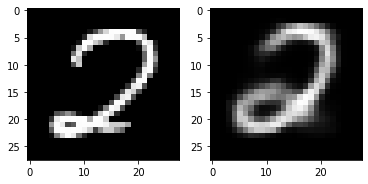

[Epoch 21]
For train data

Reconstruction : 18.185985416666668
KL Divergence : 10.1922125
Total loss : 28.378197916666668

For test data

Reconstruction : 18.140475
KL Divergence : 10.3538109375
Total loss : 28.4942859375


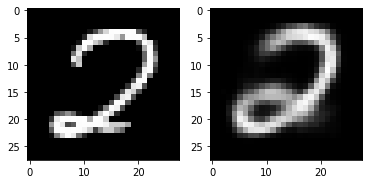

[Epoch 22]
For train data

Reconstruction : 18.12009375
KL Divergence : 10.192595833333334
Total loss : 28.31268958333333

For test data

Reconstruction : 18.344125
KL Divergence : 10.17316171875
Total loss : 28.51728671875


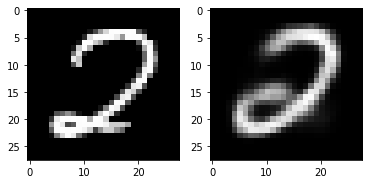

[Epoch 23]
For train data

Reconstruction : 18.062070833333333
KL Divergence : 10.223029166666667
Total loss : 28.2851

For test data

Reconstruction : 18.12013125
KL Divergence : 10.2398078125
Total loss : 28.3599390625


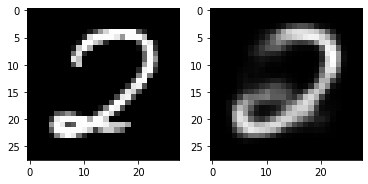

[Epoch 24]
For train data

Reconstruction : 18.026389583333334
KL Divergence : 10.252244791666667
Total loss : 28.278634375000003

For test data

Reconstruction : 17.8980796875
KL Divergence : 10.54760546875
Total loss : 28.44568515625


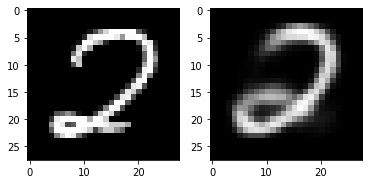

[Epoch 25]
For train data

Reconstruction : 17.947620833333332
KL Divergence : 10.257420833333333
Total loss : 28.205041666666666

For test data

Reconstruction : 17.9482796875
KL Divergence : 10.3483671875
Total loss : 28.296646875


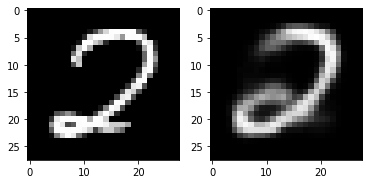

[Epoch 26]
For train data

Reconstruction : 17.905427083333333
KL Divergence : 10.278332291666667
Total loss : 28.183759375

For test data

Reconstruction : 17.9027390625
KL Divergence : 10.51244921875
Total loss : 28.41518828125


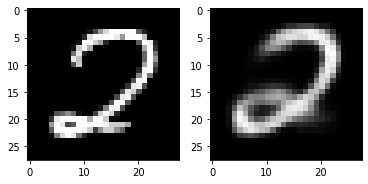

[Epoch 27]
For train data

Reconstruction : 17.870933333333333
KL Divergence : 10.272029166666666
Total loss : 28.1429625

For test data

Reconstruction : 18.2121671875
KL Divergence : 10.17140859375
Total loss : 28.383575781250002


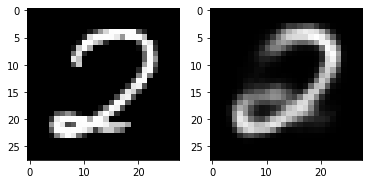

[Epoch 28]
For train data

Reconstruction : 17.825889583333332
KL Divergence : 10.288852083333333
Total loss : 28.114741666666667

For test data

Reconstruction : 18.1061765625
KL Divergence : 10.1925625
Total loss : 28.298739062499997


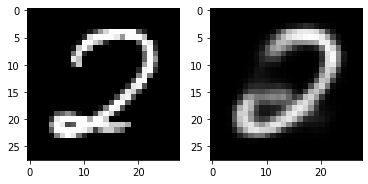

[Epoch 29]
For train data

Reconstruction : 17.77926875
KL Divergence : 10.300067708333334
Total loss : 28.079336458333334

For test data

Reconstruction : 17.863884375
KL Divergence : 10.39003828125
Total loss : 28.25392265625


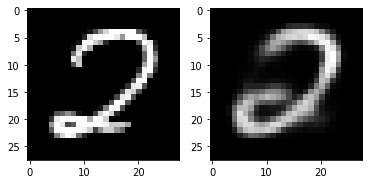

[Epoch 30]
For train data

Reconstruction : 17.74405
KL Divergence : 10.314644791666666
Total loss : 28.058694791666667

For test data

Reconstruction : 17.8194109375
KL Divergence : 10.493021875
Total loss : 28.3124328125


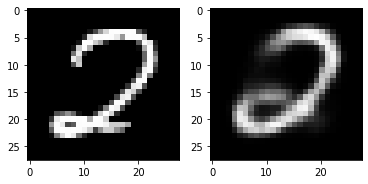

[Epoch 31]
For train data

Reconstruction : 17.698533333333334
KL Divergence : 10.316914583333334
Total loss : 28.015447916666666

For test data

Reconstruction : 17.887803125
KL Divergence : 10.3250890625
Total loss : 28.212892187500003


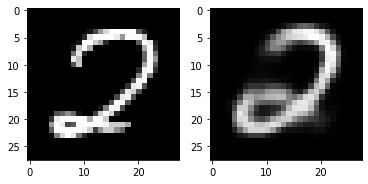

[Epoch 32]
For train data

Reconstruction : 17.667833333333334
KL Divergence : 10.326980208333334
Total loss : 27.994813541666666

For test data

Reconstruction : 17.968140625
KL Divergence : 10.2450296875
Total loss : 28.2131703125


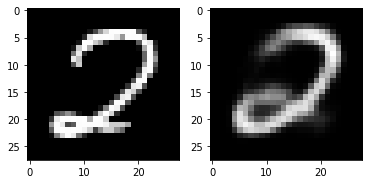

[Epoch 33]
For train data

Reconstruction : 17.642402083333334
KL Divergence : 10.354691666666668
Total loss : 27.99709375

For test data

Reconstruction : 18.0240703125
KL Divergence : 10.25229609375
Total loss : 28.27636640625


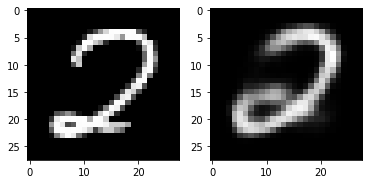

[Epoch 34]
For train data

Reconstruction : 17.601004166666666
KL Divergence : 10.37248125
Total loss : 27.973485416666666

For test data

Reconstruction : 17.8562375
KL Divergence : 10.236709375
Total loss : 28.092946875


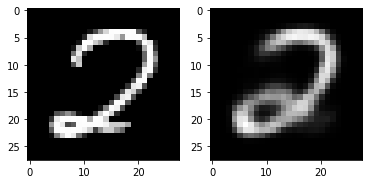

[Epoch 35]
For train data

Reconstruction : 17.58551875
KL Divergence : 10.362908333333333
Total loss : 27.948427083333332

For test data

Reconstruction : 17.883446875
KL Divergence : 10.3072984375
Total loss : 28.1907453125


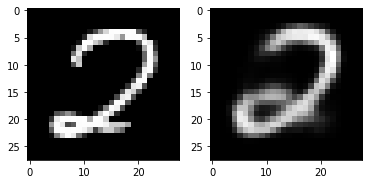

[Epoch 36]
For train data

Reconstruction : 17.54913125
KL Divergence : 10.355475
Total loss : 27.90460625

For test data

Reconstruction : 17.99986875
KL Divergence : 10.31234765625
Total loss : 28.312216406250002


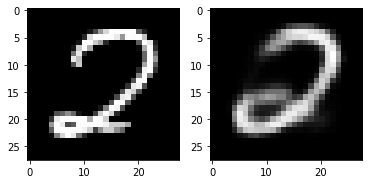

[Epoch 37]
For train data

Reconstruction : 17.52058125
KL Divergence : 10.380171875
Total loss : 27.900753125

For test data

Reconstruction : 17.610221875
KL Divergence : 10.525
Total loss : 28.135221875


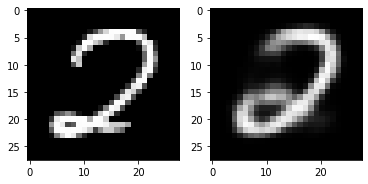

[Epoch 38]
For train data

Reconstruction : 17.498025
KL Divergence : 10.374369791666666
Total loss : 27.872394791666665

For test data

Reconstruction : 17.6822078125
KL Divergence : 10.466296875
Total loss : 28.1485046875


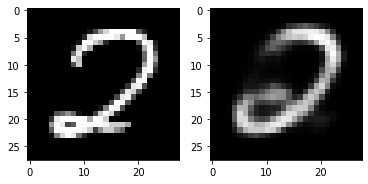

[Epoch 39]
For train data

Reconstruction : 17.462723958333335
KL Divergence : 10.385342708333333
Total loss : 27.848066666666668

For test data

Reconstruction : 17.7161296875
KL Divergence : 10.45085
Total loss : 28.166979687500003


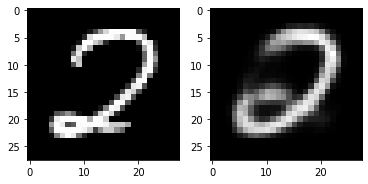

[Epoch 40]
For train data

Reconstruction : 17.430230208333334
KL Divergence : 10.408633333333333
Total loss : 27.83886354166667

For test data

Reconstruction : 17.8216453125
KL Divergence : 10.316615625
Total loss : 28.1382609375


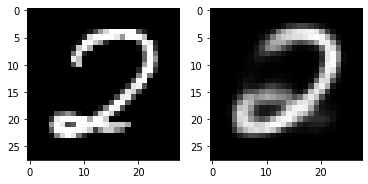

[Epoch 41]
For train data

Reconstruction : 17.422471875
KL Divergence : 10.394935416666666
Total loss : 27.817407291666665

For test data

Reconstruction : 17.5869546875
KL Divergence : 10.53646875
Total loss : 28.1234234375


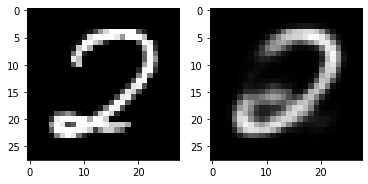

[Epoch 42]
For train data

Reconstruction : 17.397296875
KL Divergence : 10.412009375
Total loss : 27.80930625

For test data

Reconstruction : 17.7379046875
KL Divergence : 10.39503671875
Total loss : 28.132941406249998


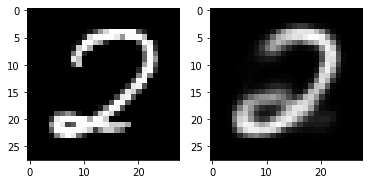

[Epoch 43]
For train data

Reconstruction : 17.361082291666666
KL Divergence : 10.417601041666666
Total loss : 27.778683333333333

For test data

Reconstruction : 17.5643546875
KL Divergence : 10.43384453125
Total loss : 27.99819921875


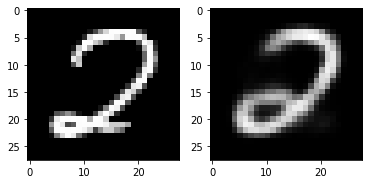

[Epoch 44]
For train data

Reconstruction : 17.344070833333333
KL Divergence : 10.425069791666667
Total loss : 27.769140625

For test data

Reconstruction : 17.5309203125
KL Divergence : 10.44334140625
Total loss : 27.97426171875


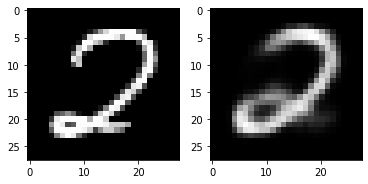

[Epoch 45]
For train data

Reconstruction : 17.329361458333334
KL Divergence : 10.406263541666666
Total loss : 27.735625

For test data

Reconstruction : 17.7015359375
KL Divergence : 10.2947859375
Total loss : 27.996321875


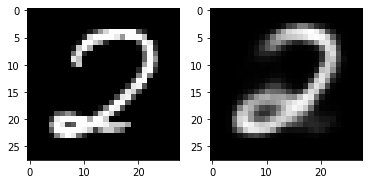

[Epoch 46]
For train data

Reconstruction : 17.311035416666666
KL Divergence : 10.427596875
Total loss : 27.73863229166667

For test data

Reconstruction : 17.7166765625
KL Divergence : 10.3755375
Total loss : 28.0922140625


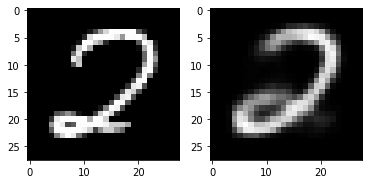

[Epoch 47]
For train data

Reconstruction : 17.2807875
KL Divergence : 10.443601041666666
Total loss : 27.724388541666663

For test data

Reconstruction : 17.6470171875
KL Divergence : 10.424184375
Total loss : 28.0712015625


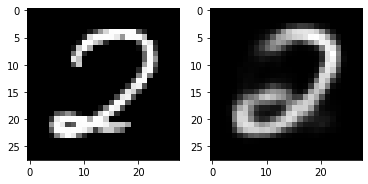

[Epoch 48]
For train data

Reconstruction : 17.264404166666665
KL Divergence : 10.446330208333332
Total loss : 27.710734374999998

For test data

Reconstruction : 17.715815625
KL Divergence : 10.297315625
Total loss : 28.01313125


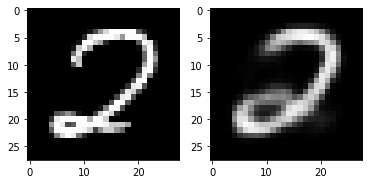

[Epoch 49]
For train data

Reconstruction : 17.25145625
KL Divergence : 10.433908333333333
Total loss : 27.68536458333333

For test data

Reconstruction : 17.61589375
KL Divergence : 10.361375
Total loss : 27.97726875


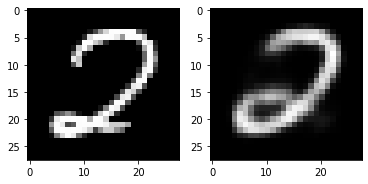

[Epoch 50]
For train data

Reconstruction : 17.238123958333333
KL Divergence : 10.453163541666667
Total loss : 27.6912875

For test data

Reconstruction : 17.650571875
KL Divergence : 10.4549234375
Total loss : 28.1054953125


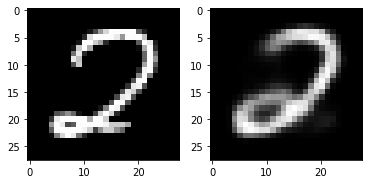

[Epoch 51]
For train data

Reconstruction : 17.219189583333332
KL Divergence : 10.446455208333333
Total loss : 27.665644791666665

For test data

Reconstruction : 17.6301046875
KL Divergence : 10.34262421875
Total loss : 27.97272890625


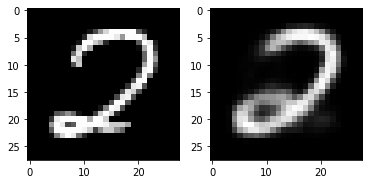

[Epoch 52]
For train data

Reconstruction : 17.194811458333334
KL Divergence : 10.458477083333333
Total loss : 27.65328854166667

For test data

Reconstruction : 17.590390625
KL Divergence : 10.370303125
Total loss : 27.96069375


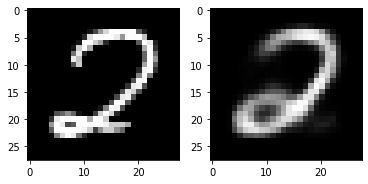

[Epoch 53]
For train data

Reconstruction : 17.157490625
KL Divergence : 10.482175
Total loss : 27.639665625

For test data

Reconstruction : 17.5096671875
KL Divergence : 10.42275078125
Total loss : 27.932417968750002


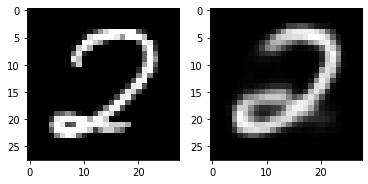

[Epoch 54]
For train data

Reconstruction : 17.162220833333333
KL Divergence : 10.47085
Total loss : 27.633070833333335

For test data

Reconstruction : 17.464903125
KL Divergence : 10.40247421875
Total loss : 27.86737734375


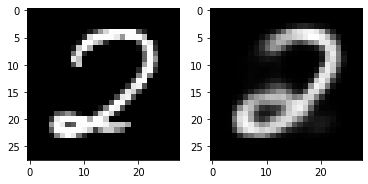

[Epoch 55]
For train data

Reconstruction : 17.144207291666667
KL Divergence : 10.4848875
Total loss : 27.629094791666667

For test data

Reconstruction : 17.3620109375
KL Divergence : 10.69482265625
Total loss : 28.05683359375


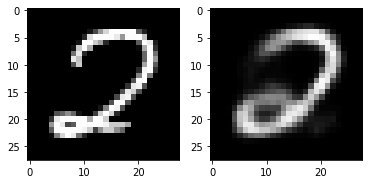

[Epoch 56]
For train data

Reconstruction : 17.131532291666666
KL Divergence : 10.494711458333333
Total loss : 27.62624375

For test data

Reconstruction : 17.463984375
KL Divergence : 10.47453828125
Total loss : 27.93852265625


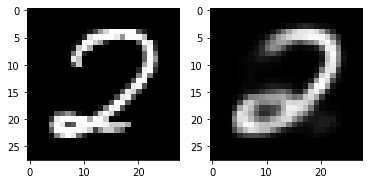

[Epoch 57]
For train data

Reconstruction : 17.12186875
KL Divergence : 10.502601041666667
Total loss : 27.62446979166667

For test data

Reconstruction : 17.4037578125
KL Divergence : 10.51721328125
Total loss : 27.920971093749998


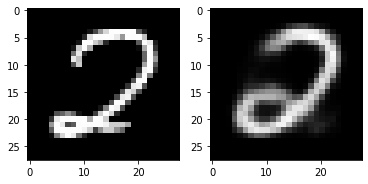

[Epoch 58]
For train data

Reconstruction : 17.113057291666667
KL Divergence : 10.485479166666666
Total loss : 27.598536458333335

For test data

Reconstruction : 17.631909375
KL Divergence : 10.35835546875
Total loss : 27.990264843749998


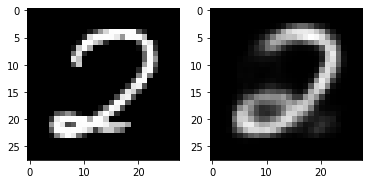

[Epoch 59]
For train data

Reconstruction : 17.092319791666668
KL Divergence : 10.489138541666666
Total loss : 27.581458333333334

For test data

Reconstruction : 17.5123765625
KL Divergence : 10.42852421875
Total loss : 27.94090078125


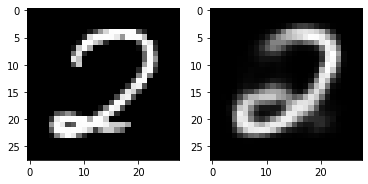

[Epoch 60]
For train data

Reconstruction : 17.06169166666667
KL Divergence : 10.516346875
Total loss : 27.57803854166667

For test data

Reconstruction : 17.4493125
KL Divergence : 10.42147578125
Total loss : 27.87078828125


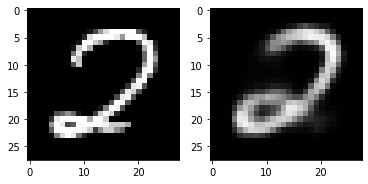

[Epoch 61]
For train data

Reconstruction : 17.061091666666666
KL Divergence : 10.475923958333333
Total loss : 27.537015625

For test data

Reconstruction : 17.4482265625
KL Divergence : 10.5261359375
Total loss : 27.974362499999998


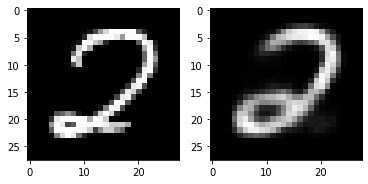

[Epoch 62]
For train data

Reconstruction : 17.051782291666665
KL Divergence : 10.517840625
Total loss : 27.569622916666667

For test data

Reconstruction : 17.464459375
KL Divergence : 10.52779375
Total loss : 27.992253125


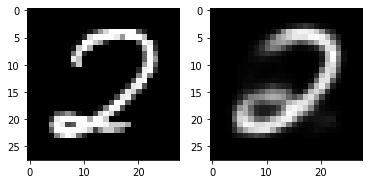

[Epoch 63]
For train data

Reconstruction : 17.021159375
KL Divergence : 10.503938541666667
Total loss : 27.525097916666667

For test data

Reconstruction : 17.313921875
KL Divergence : 10.5148734375
Total loss : 27.8287953125


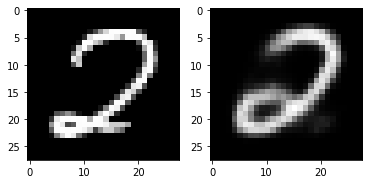

[Epoch 64]
For train data

Reconstruction : 17.023802083333333
KL Divergence : 10.518164583333334
Total loss : 27.541966666666667

For test data

Reconstruction : 17.2164640625
KL Divergence : 10.6082140625
Total loss : 27.824678125


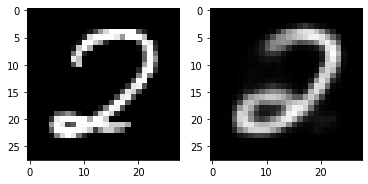

[Epoch 65]
For train data

Reconstruction : 17.015303125
KL Divergence : 10.536758333333333
Total loss : 27.552061458333334

For test data

Reconstruction : 17.378125
KL Divergence : 10.439365625
Total loss : 27.817490625


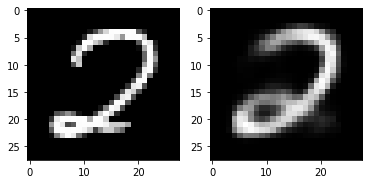

[Epoch 66]
For train data

Reconstruction : 17.006380208333333
KL Divergence : 10.512983333333333
Total loss : 27.519363541666664

For test data

Reconstruction : 17.228884375
KL Divergence : 10.62821015625
Total loss : 27.85709453125


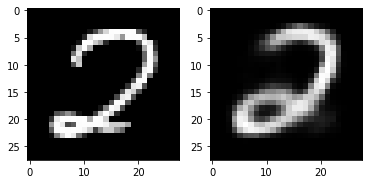

[Epoch 67]
For train data

Reconstruction : 16.97346458333333
KL Divergence : 10.554375
Total loss : 27.527839583333332

For test data

Reconstruction : 17.3106328125
KL Divergence : 10.56691171875
Total loss : 27.87754453125


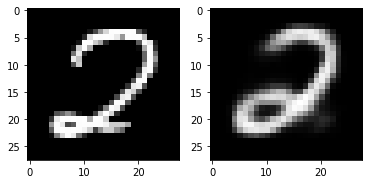

[Epoch 68]
For train data

Reconstruction : 16.959996875
KL Divergence : 10.540435416666666
Total loss : 27.50043229166667

For test data

Reconstruction : 17.2365015625
KL Divergence : 10.55201875
Total loss : 27.788520312499998


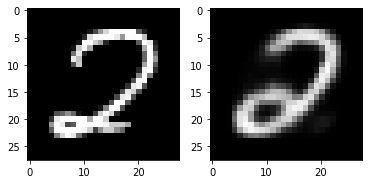

[Epoch 69]
For train data

Reconstruction : 16.962721875
KL Divergence : 10.532485416666667
Total loss : 27.495207291666667

For test data

Reconstruction : 17.4843515625
KL Divergence : 10.43297734375
Total loss : 27.91732890625


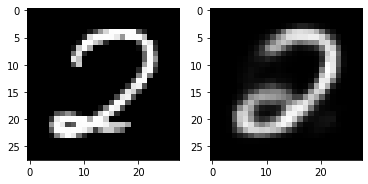

[Epoch 70]
For train data

Reconstruction : 16.935863541666667
KL Divergence : 10.526480208333334
Total loss : 27.462343750000002

For test data

Reconstruction : 17.43279375
KL Divergence : 10.5052125
Total loss : 27.93800625


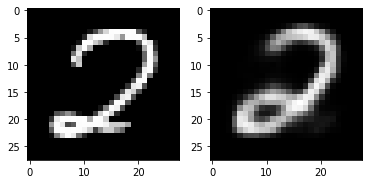

[Epoch 71]
For train data

Reconstruction : 16.945114583333332
KL Divergence : 10.543944791666666
Total loss : 27.489059374999997

For test data

Reconstruction : 17.371909375
KL Divergence : 10.55930078125
Total loss : 27.931210156250003


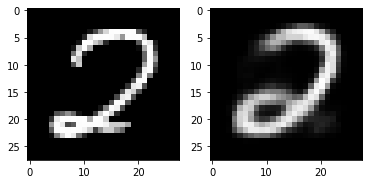

[Epoch 72]
For train data

Reconstruction : 16.906713541666665
KL Divergence : 10.540484375
Total loss : 27.447197916666667

For test data

Reconstruction : 17.4460734375
KL Divergence : 10.40318359375
Total loss : 27.84925703125


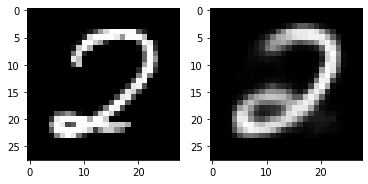

[Epoch 73]
For train data

Reconstruction : 16.913363541666666
KL Divergence : 10.554821875
Total loss : 27.468185416666664

For test data

Reconstruction : 17.2240203125
KL Divergence : 10.61321484375
Total loss : 27.83723515625


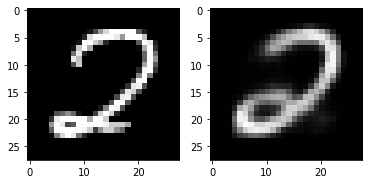

[Epoch 74]
For train data

Reconstruction : 16.914801041666667
KL Divergence : 10.532317708333334
Total loss : 27.44711875

For test data

Reconstruction : 17.108665625
KL Divergence : 10.71891171875
Total loss : 27.82757734375


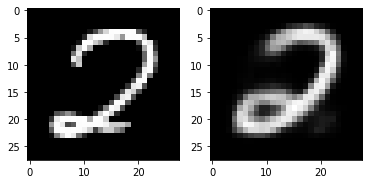

[Epoch 75]
For train data

Reconstruction : 16.900986458333332
KL Divergence : 10.573296875
Total loss : 27.474283333333332

For test data

Reconstruction : 17.5778765625
KL Divergence : 10.3024859375
Total loss : 27.880362499999997


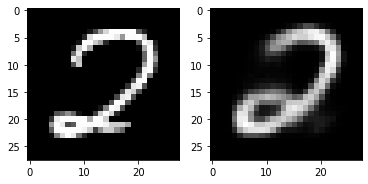

[Epoch 76]
For train data

Reconstruction : 16.873034375
KL Divergence : 10.560982291666667
Total loss : 27.434016666666665

For test data

Reconstruction : 17.0727578125
KL Divergence : 10.7092734375
Total loss : 27.782031250000003


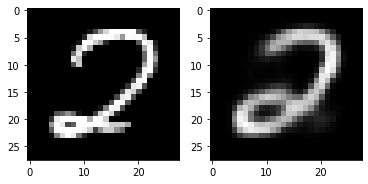

[Epoch 77]
For train data

Reconstruction : 16.879064583333335
KL Divergence : 10.572360416666667
Total loss : 27.451425

For test data

Reconstruction : 17.2531375
KL Divergence : 10.716975
Total loss : 27.9701125


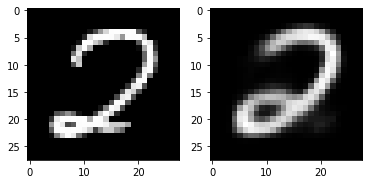

[Epoch 78]
For train data

Reconstruction : 16.866191666666666
KL Divergence : 10.558077083333334
Total loss : 27.42426875

For test data

Reconstruction : 17.330625
KL Divergence : 10.49782734375
Total loss : 27.82845234375


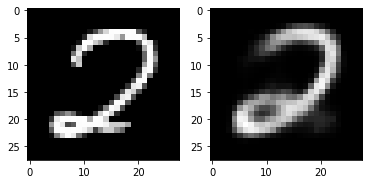

[Epoch 79]
For train data

Reconstruction : 16.864276041666667
KL Divergence : 10.567269791666666
Total loss : 27.43154583333333

For test data

Reconstruction : 17.298803125
KL Divergence : 10.59436328125
Total loss : 27.89316640625


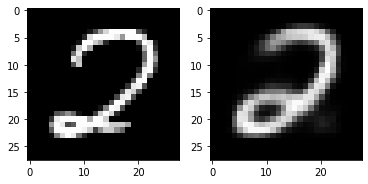

[Epoch 80]
For train data

Reconstruction : 16.84501145833333
KL Divergence : 10.562908333333333
Total loss : 27.407919791666664

For test data

Reconstruction : 17.196290625
KL Divergence : 10.64756171875
Total loss : 27.84385234375


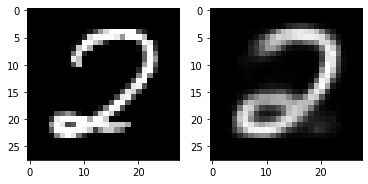

[Epoch 81]
For train data

Reconstruction : 16.833778125
KL Divergence : 10.561576041666667
Total loss : 27.395354166666664

For test data

Reconstruction : 17.3806921875
KL Divergence : 10.4934578125
Total loss : 27.87415


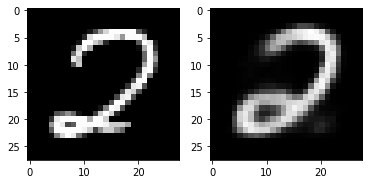

[Epoch 82]
For train data

Reconstruction : 16.825979166666666
KL Divergence : 10.566526041666666
Total loss : 27.392505208333333

For test data

Reconstruction : 17.32495625
KL Divergence : 10.51019453125
Total loss : 27.83515078125


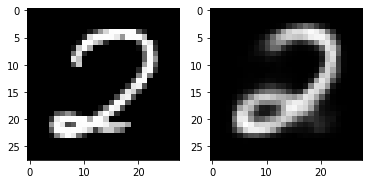

[Epoch 83]
For train data

Reconstruction : 16.832720833333333
KL Divergence : 10.5777
Total loss : 27.410420833333333

For test data

Reconstruction : 17.28803125
KL Divergence : 10.506978125
Total loss : 27.795009375


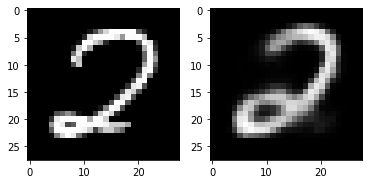

[Epoch 84]
For train data

Reconstruction : 16.791430208333335
KL Divergence : 10.578280208333334
Total loss : 27.36971041666667

For test data

Reconstruction : 17.557909375
KL Divergence : 10.37705546875
Total loss : 27.934964843750002


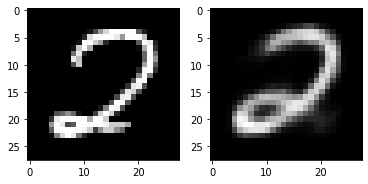

[Epoch 85]
For train data

Reconstruction : 16.811784375
KL Divergence : 10.574686458333334
Total loss : 27.386470833333334

For test data

Reconstruction : 17.38886875
KL Divergence : 10.5611984375
Total loss : 27.9500671875


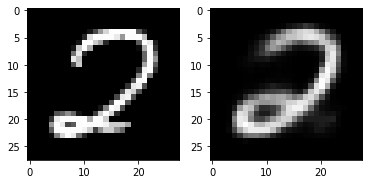

[Epoch 86]
For train data

Reconstruction : 16.798498958333333
KL Divergence : 10.576720833333333
Total loss : 27.375219791666666

For test data

Reconstruction : 17.1977546875
KL Divergence : 10.6738921875
Total loss : 27.871646875000003


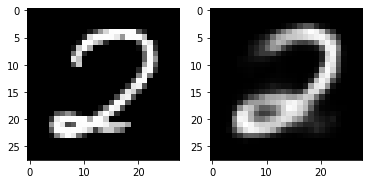

[Epoch 87]
For train data

Reconstruction : 16.78765
KL Divergence : 10.595477083333334
Total loss : 27.383127083333335

For test data

Reconstruction : 17.08936875
KL Divergence : 10.72022734375
Total loss : 27.80959609375


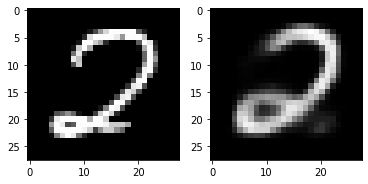

[Epoch 88]
For train data

Reconstruction : 16.754310416666666
KL Divergence : 10.596653125
Total loss : 27.350963541666665

For test data

Reconstruction : 17.2661390625
KL Divergence : 10.5601078125
Total loss : 27.826246875


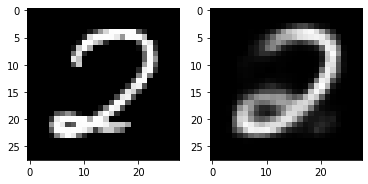

[Epoch 89]
For train data

Reconstruction : 16.756286458333335
KL Divergence : 10.61881875
Total loss : 27.375105208333338

For test data

Reconstruction : 17.1991296875
KL Divergence : 10.54595859375
Total loss : 27.745088281250002


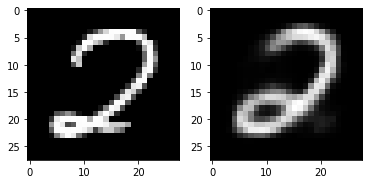

[Epoch 90]
For train data

Reconstruction : 16.76776041666667
KL Divergence : 10.584990625
Total loss : 27.352751041666668

For test data

Reconstruction : 17.20020625
KL Divergence : 10.6227703125
Total loss : 27.822976562500003


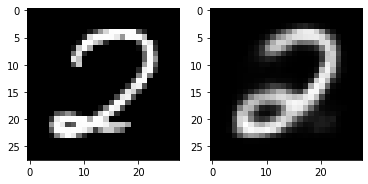

[Epoch 91]
For train data

Reconstruction : 16.746945833333335
KL Divergence : 10.593016666666667
Total loss : 27.339962500000002

For test data

Reconstruction : 17.230965625
KL Divergence : 10.6387078125
Total loss : 27.869673437499998


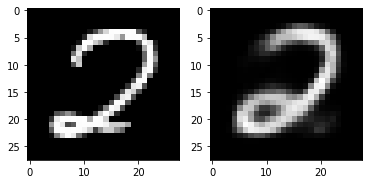

[Epoch 92]
For train data

Reconstruction : 16.724891666666668
KL Divergence : 10.618591666666667
Total loss : 27.343483333333335

For test data

Reconstruction : 17.2848890625
KL Divergence : 10.4672390625
Total loss : 27.752128125


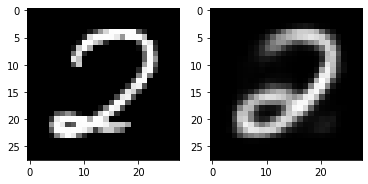

[Epoch 93]
For train data

Reconstruction : 16.736603125
KL Divergence : 10.606842708333334
Total loss : 27.343445833333334

For test data

Reconstruction : 17.4181890625
KL Divergence : 10.37008359375
Total loss : 27.78827265625


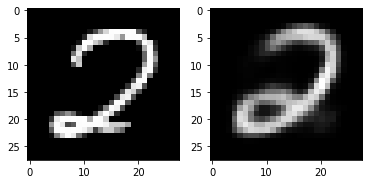

[Epoch 94]
For train data

Reconstruction : 16.715111458333332
KL Divergence : 10.603844791666667
Total loss : 27.31895625

For test data

Reconstruction : 17.2411890625
KL Divergence : 10.5203640625
Total loss : 27.761553125


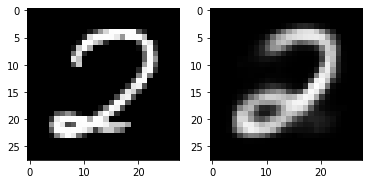

[Epoch 95]
For train data

Reconstruction : 16.718236458333333
KL Divergence : 10.6157625
Total loss : 27.333998958333332

For test data

Reconstruction : 17.2871515625
KL Divergence : 10.5578125
Total loss : 27.8449640625


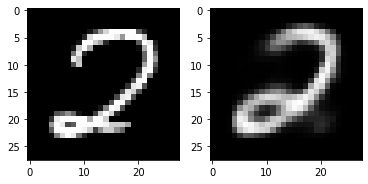

[Epoch 96]
For train data

Reconstruction : 16.7158375
KL Divergence : 10.614215625
Total loss : 27.330053125

For test data

Reconstruction : 17.2417578125
KL Divergence : 10.5991078125
Total loss : 27.840865625


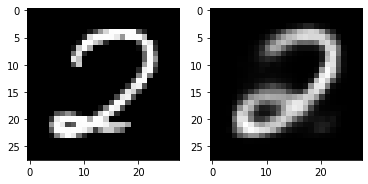

[Epoch 97]
For train data

Reconstruction : 16.701147916666667
KL Divergence : 10.619248958333333
Total loss : 27.320396875

For test data

Reconstruction : 17.354184375
KL Divergence : 10.53603125
Total loss : 27.890215625


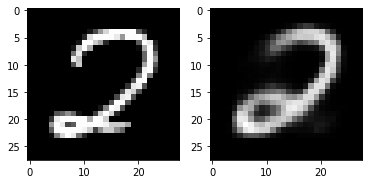

[Epoch 98]
For train data

Reconstruction : 16.679682291666666
KL Divergence : 10.619896875
Total loss : 27.299579166666668

For test data

Reconstruction : 17.319359375
KL Divergence : 10.5760765625
Total loss : 27.895435937500004


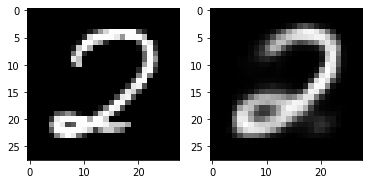

[Epoch 99]
For train data

Reconstruction : 16.69268125
KL Divergence : 10.605792708333333
Total loss : 27.298473958333332

For test data

Reconstruction : 17.061078125
KL Divergence : 10.78086796875
Total loss : 27.841946093750003


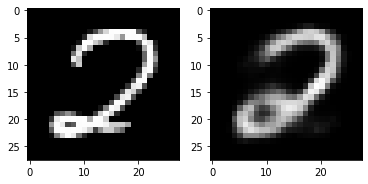

[Epoch 100]
For train data

Reconstruction : 16.690215625
KL Divergence : 10.6019
Total loss : 27.292115625

For test data

Reconstruction : 17.0767015625
KL Divergence : 10.67467109375
Total loss : 27.75137265625


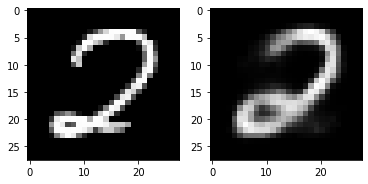

In [14]:
vae, a, b, c, d, e, f = train(vae, train_loader, test_loader, epochs=MAX_EPOCHS)

Plot loss functions
=====

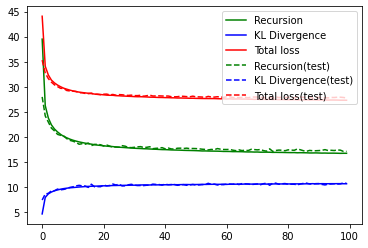

In [15]:
plt.plot(a, 'g', label = 'Recursion')
plt.plot(b, 'b', label = 'KL Divergence')
plt.plot(c, 'r', label = 'Total loss')
plt.plot(d, 'g--', label = 'Recursion(test)')
plt.plot(e, 'b--', label = 'KL Divergence(test)')
plt.plot(f, 'r--', label = 'Total loss(test)')
plt.legend(loc='best') 
plt.show()


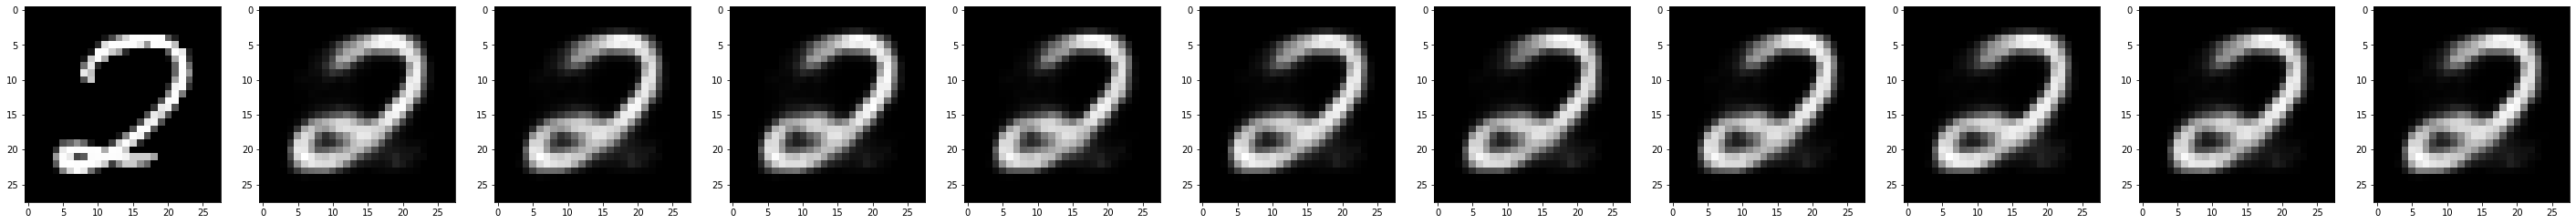

tensor([[ 0.0151, -0.4160, -0.0084, -0.0397, -0.0227, -0.8728, -0.8828,  0.0067,
         -0.0138,  2.1753,  0.0185, -0.0427,  1.6663,  0.3020,  0.0200,  0.0463]])
tensor([[0.9979, 0.0989, 0.9834, 1.0137, 0.9988, 0.1944, 0.2633, 0.9991, 1.0210,
         0.3752, 0.9585, 0.9847, 0.1536, 0.1609, 0.9950, 0.1493]])


In [16]:
n_samples = 10
with torch.no_grad():
    vae.eval()
    _, sample_mu, sample_sigma = vae.encoder(sample)
    sample_np = sample.cpu().detach().numpy()
    original = np.reshape(sample_np, (28,28))
    plt.figure(figsize=(50,550))
    plt.subplot(1, n_samples+1, 1)
    plt.imshow(original, cmap='gray')
    for j in range(n_samples):
        epsilon = torch.rand_like(sample_mu).to(device)
        latent_vec = sample_mu + sample_sigma * epsilon * 1.0
        decoded_sample = vae.decoder(latent_vec)
        decoded_np = decoded_sample.cpu().detach().numpy()
        make = np.reshape(decoded_np, (28,28))
        plt.subplot(1, n_samples+1, j+2)
        plt.imshow(make, cmap='gray')
    plt.show()
    print(sample_mu)
    print(sample_sigma)